#Библиотеки

In [ ]:
!pip install lxml
!pip install requests
!pip install beautifulsoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from csv import writer
current_date = date.today()
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import datetime

delta = datetime.timedelta(days=1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


----------------

#Функция для графика

In [ ]:
def grafic(name, date, s):
  date.rename(columns={'Price' : 'График цены'}, inplace=True)

  date.plot(figsize=(14, 5), label='График цены').set_title(name)
  s.plot(label='Прогноз', color='red')
  plt.legend()
  # plt.text(s.index[-1],s[-1], 'Прогноз на' + ' ' + (str((fqs.index[-1])))[0 : 10] + ' ' + '-' + ' ' + str(fqs[-1]) + ' ' + 'р', weight="bold")
  plt.text(s.index[-1],s[-1], 'Прогноз', weight="bold", color='red')
  plt.xlabel('Цена на' + ' ' + (str(date.index[-1]))[0 : 10] + ' ' + '-' + ' ' + str(date['График цены'][-1]) + ' ' + 'р.'
  "\n"
  'Прогноз на'+ ' ' + (str((s.index[-1])))[0 : 10] + ' ' + '-' + ' '+ str(s[-1]) + ' ' + 'р'
  , weight="bold")

In [ ]:
# гистограмма
def hist(l, name):
  
  
  plt.figure(figsize=(15, 5))
  ax = sns.histplot(data=pd.Series(l.iloc[-1::].values.T.flatten())).set_title('Распределение цен' + ' ' + name + ' ' + 'на' + ' ' + str(current_date))
  plt.ylabel('Количество предложений')
  plt.xlabel('Цена')


# Функция для парсинга с графиком

In [ ]:
def clear_text(text):
    s = re.sub(r'[^0123456789]', ' ', text) 
    s = " ".join(s.split())
    return s
def first(u):
  try:
    o = (u.split())[0]
    return o
  except:
    return 0

In [ ]:
def fish(urleses, cutting_p, names):
  url = urleses
  massiv= []

  for urles in url:
    response = requests.get(urles)
    soup = BeautifulSoup(response.text, 'lxml')
    tags = soup.find_all('a', class_='pricetable_title')
    quotes = soup.find_all('td', class_='prices_price_column')
    for i in range(0, len(quotes)):
        massiv.append(tags[i].text)
        massiv.append(quotes[i].text)

  ind_m = []
  for element in range(0, len(massiv), 2):
    ind_m.append(massiv[element])

  col_m = []
  for element in range(1, len(massiv), 2):
    col_m.append(massiv[element])

  massiv_1 = pd.DataFrame(index=ind_m, data=col_m)
  massiv_1[0] = massiv_1[0].apply(clear_text)
  massiv_1[0] = massiv_1[0].apply(first)
  massiv_1 = massiv_1.rename_axis('Номенклатура').reset_index()
  massiv_1 = massiv_1.rename(columns={0 : 'Цена'})
  
  massiv_1['Номенклатура'] = massiv_1['Номенклатура'].apply(cutting_p)
  massiv_1 = massiv_1.query('Номенклатура != "No"').copy()
  massiv_1['Цена'] = massiv_1['Цена'].astype('int64')
  massiv_1 = massiv_1.query('Цена > 30').copy()
  massiv_1 = massiv_1.query('Цена < 2000').copy()

# добавляем все значения
  uniq = (massiv_1['Номенклатура']).unique()
  print(uniq)
  # list_data = ['Date']
  # for el in range(400):
  #   list_data.append(el)
  
  
  for element in uniq:
    list_data = [current_date]
    r = list(massiv_1.loc[massiv_1['Номенклатура'] == element]['Цена'])
    print(r)
    
    for i in r:
      list_data.append(i)


    with open('/content/drive/MyDrive/Мониторинг/'+ names + '_all' + '/' + element +'_all' +'.csv', 'a', newline='') as all_object:
      writer_object = writer(all_object)
      writer_object.writerow(list_data)
      all_object.close()

# добавляем медиану для графика
  median_all = massiv_1.groupby('Номенклатура')['Цена'].median()
  pdf = PdfPages('/content/drive/MyDrive/Мониторинг/Мониторинг графики pdf/' + names + '.pdf')
  for row in range(len(median_all)):
    median = median_all[row]
    name = median_all.index[row]
    #list_data=['Date', 'Price']
    list_data=[current_date, median]
    with open('/content/drive/MyDrive/Мониторинг/'+ names + '/' + name +'.csv', 'a', newline='') as f_object:  
      writer_object = writer(f_object)
      writer_object.writerow(list_data)
      f_object.close()

# делаем предсказание и рисуем график
    q = pd.read_csv('/content/drive/MyDrive/Мониторинг/' + names + '/' + name +'.csv', index_col = [0], parse_dates=[0])
    model = SimpleExpSmoothing(q)
    model_fit = model.fit()
    fqs = model_fit.predict(len(q) - 1, len(q))
    fqs = fqs.rename(index={fqs.index[0] : q.index[-1]})
    #fqs = fqs.rename(index={fqs.index[1] : fqs.index[0] + (q.index[-1] - q.index[-2])})
    fqs = fqs.rename(index={fqs.index[1] : fqs.index[0] + delta})

    fqs[0] = q['Price'][-1]
    fqs[1] = round(fqs[1])
    pdf.savefig(grafic(name, q, fqs))

# гистограмма

    l = pd.read_csv('/content/drive/MyDrive/Мониторинг/'+ names + '_all' + '/' + name +'_all' +'.csv', index_col = [0], parse_dates=[0])
    pdf.savefig(hist(l, name))


  pdf.close()


#Окунь new

In [ ]:
urleses = ['https://www.fishnet.ru/pricelist/russia/okun_morskoy/svejemorojenaya_morojenaya_ryiba_moreproduktyi/',
      'https://www.fishnet.ru/pricelist/russia/okun_morskoy/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=2']

def cutting_p(i):
  if '300-500' in i:
    return 'Окунь 300-500'
  if '300-' in i:
    return 'Окунь 300-'
  if '500-700' in i:
    return 'Окунь 500-700'
  if '150-300' in i:
    return 'Окунь 150-300'
  if '1000г+' in i:
    return 'Окунь 1кг+'
  if '1-2' in i:
    return 'Окунь 1кг+'
  if '100-200' in i:
    return 'Окунь 100-200'
  if '35-40' in i:
    return 'Минтай бг 35+'
  if '300--500' in i:
    return 'Окунь 300-500'
  else:
    return 'No'

['Окунь 300-500' 'Окунь 150-300' 'Окунь 300-' 'Окунь 1кг+']
[283, 320, 289, 329, 327, 287, 290, 335, 285, 330, 341, 325, 330, 345, 305, 330, 295, 310, 250, 322, 319, 316, 290]
[237, 273, 265, 187, 260, 285, 285, 263, 271, 276, 275, 295, 280, 287, 260, 266, 272, 265, 240]
[265, 247, 230]
[347, 370, 370]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dis

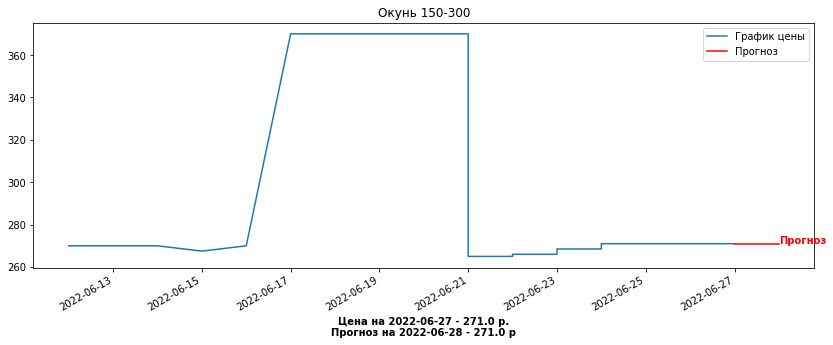

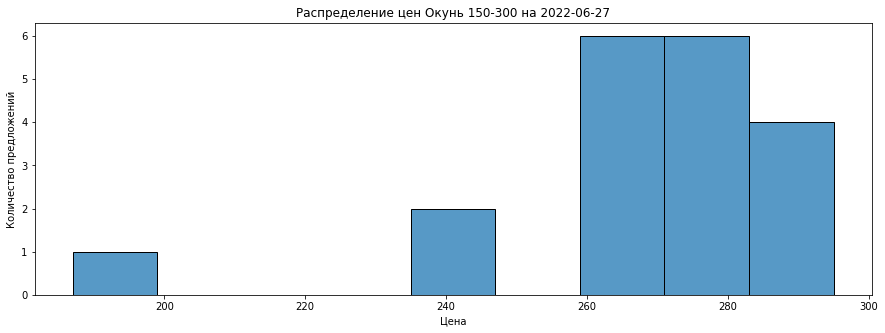

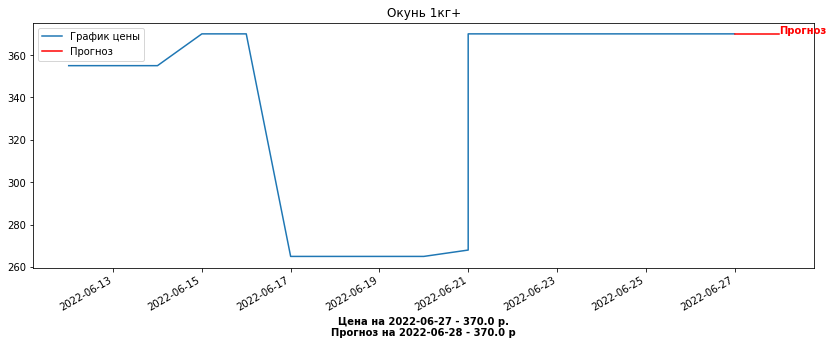

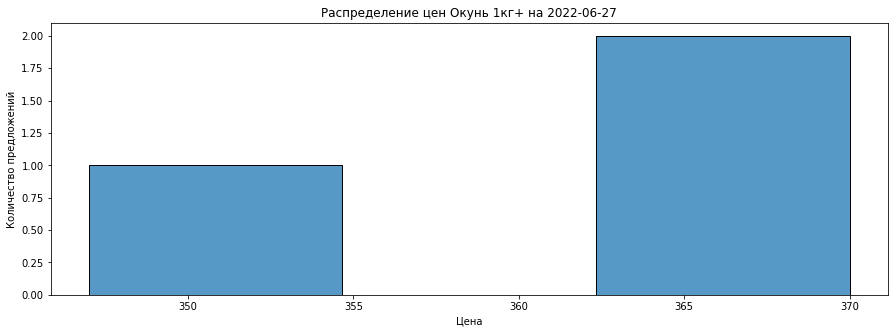

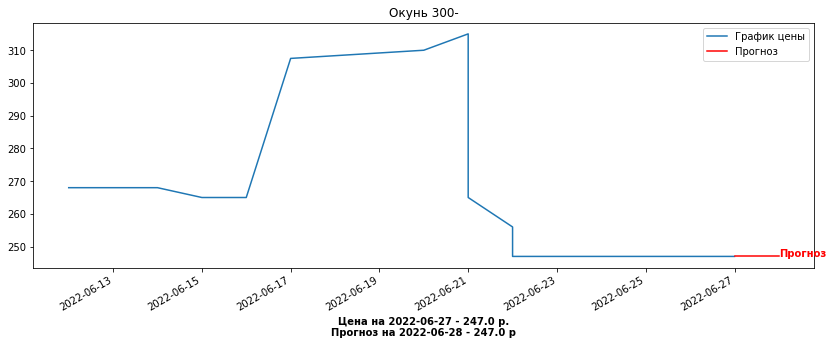

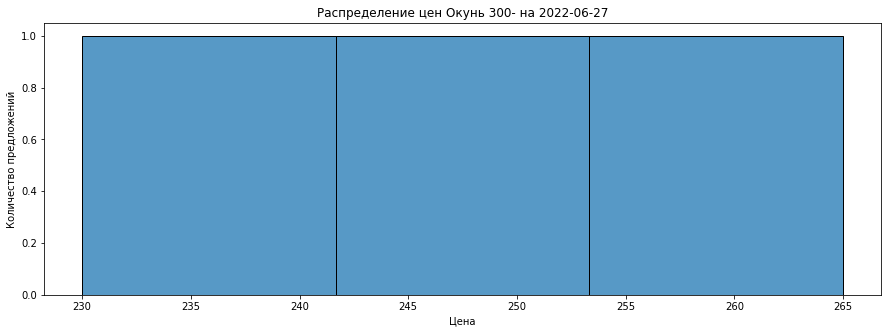

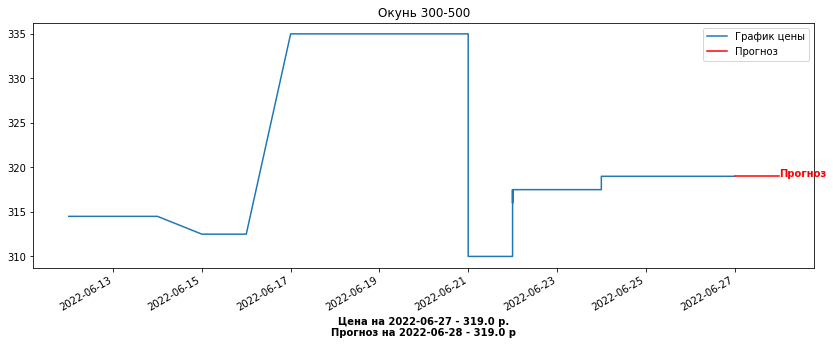

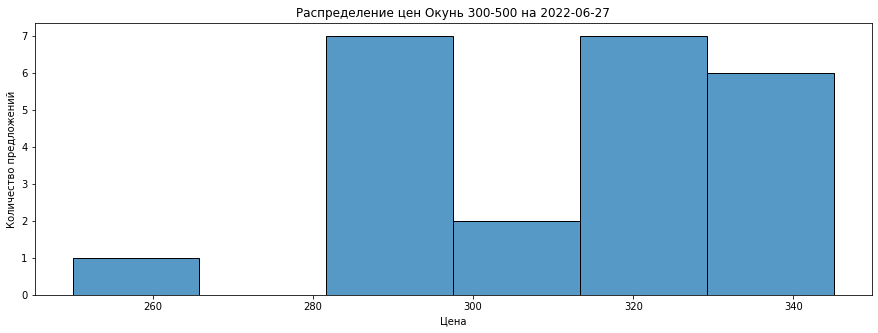

In [ ]:
fish(urleses, cutting_p, 'Окунь')

#Путассу

In [ ]:
urleses = ['https://www.fishnet.ru/pricelist/russia/putassu/svejemorojenaya_morojenaya_ryiba_moreproduktyi/', 'https://www.fishnet.ru/pricelist/russia/putassu/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=2']

def cutting_p(i):
  if '21+' in i:
    return 'Путассу 21+'
  if '18+' in i:
    return 'Путассу 18+'
  if '21-30' in i:
    return 'Путассу 21+'
  if '20+' in i:
    return 'Путассу 20+'
  else:
    return 'No'

['Путассу 21+' 'Путассу 18+' 'Путассу 20+']
[82, 78, 75, 67, 71, 66, 69, 78, 85, 68, 84, 84, 68, 91]
[70, 64, 73, 68, 61, 65, 65, 64, 61, 65]
[83]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:924: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:930: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associ

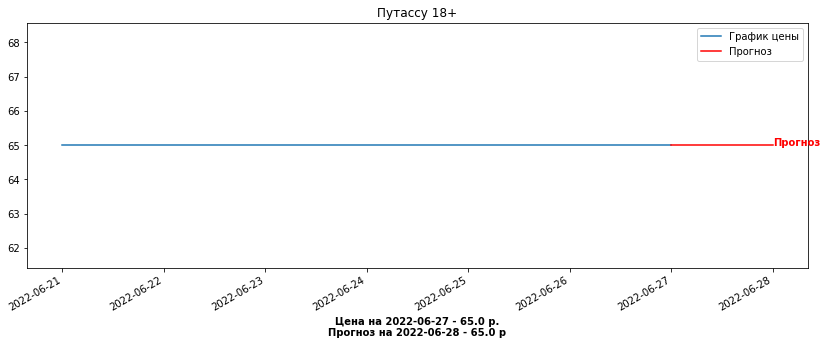

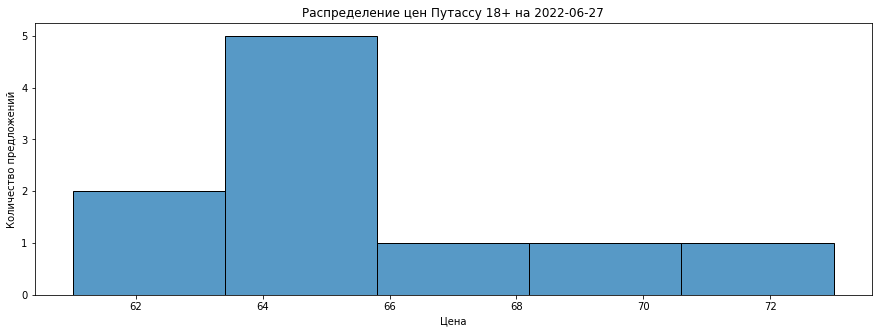

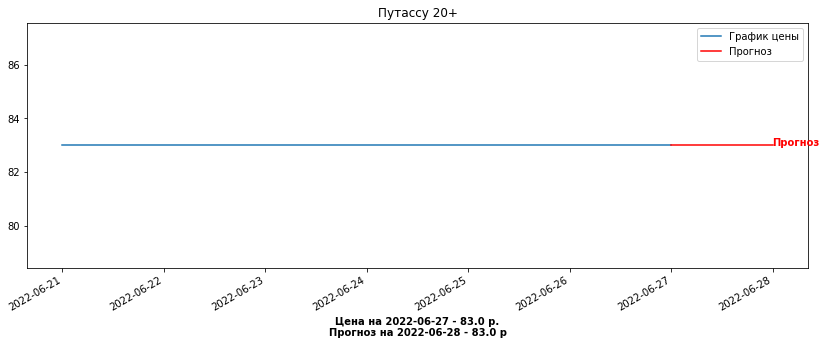

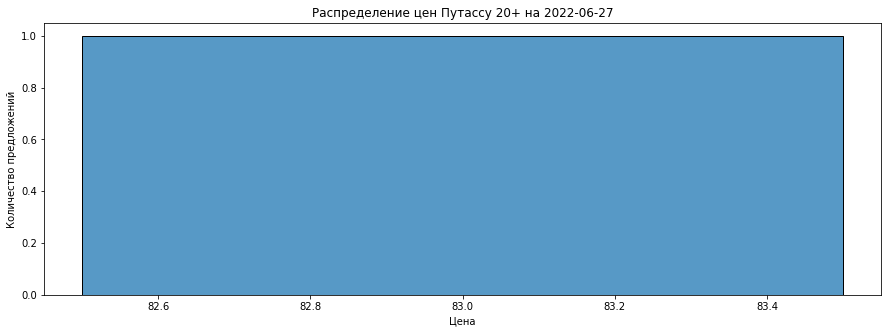

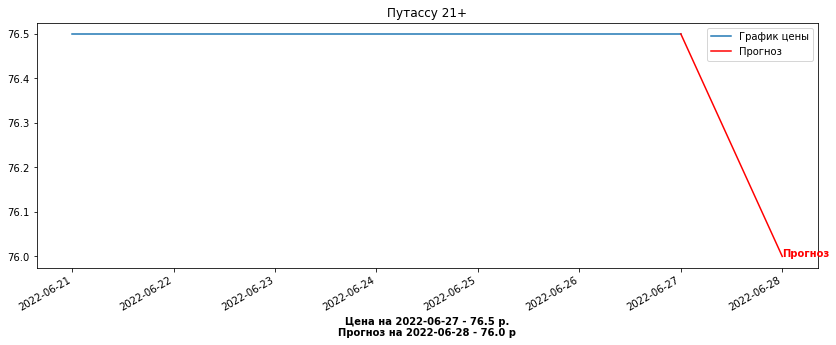

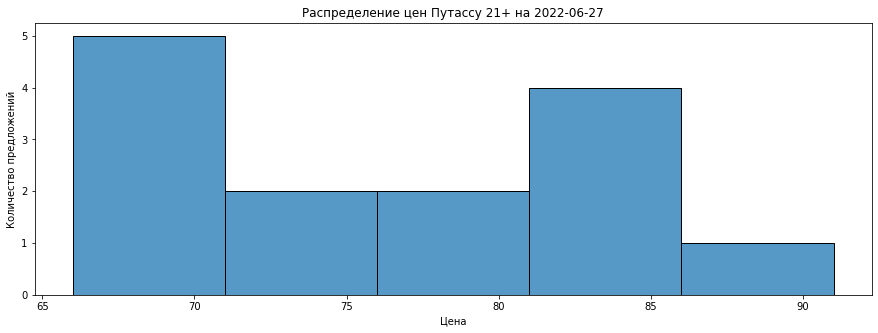

In [ ]:
fish(urleses, cutting_p, 'Путассу')

#Зубатка

In [ ]:
urleses = ['https://www.fishnet.ru/pricelist/russia/zubatka_sinyaya/svejemorojenaya_morojenaya_ryiba_moreproduktyi/']

def cutting_p(i):
  if 'Хво' in i:
    return 'No'
  if 'хво' in i:
    return 'No'
  if 'стейк' in i:
    return 'No'
  else:
    return 'Зубатка синяя'

['Зубатка синяя']
[170, 152, 154, 145, 155, 161, 155, 162, 162, 136, 139, 125, 140, 142, 139, 129, 155, 123, 140, 163]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:924: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:930: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


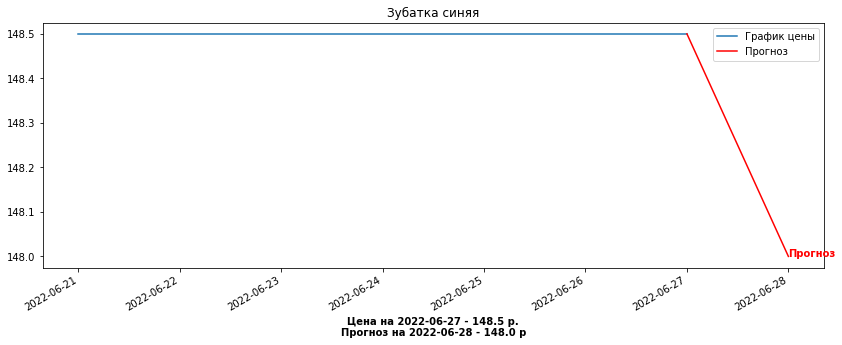

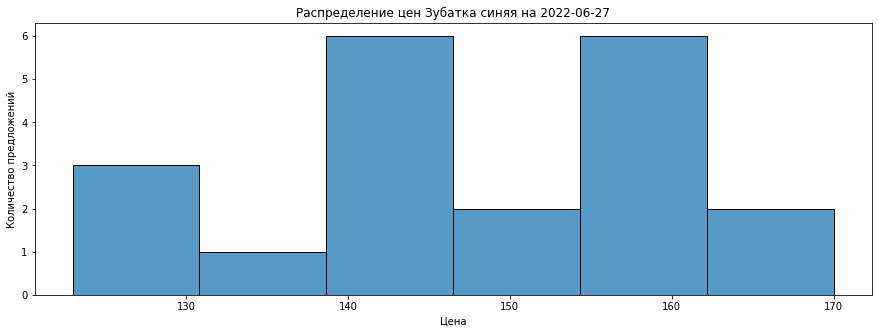

In [ ]:
fish(urleses, cutting_p, 'Зубатка')

# Кальмар new

In [ ]:
urleses = ['https://www.fishnet.ru/pricelist/russia/kalmar/svejemorojenaya_morojenaya_ryiba_moreproduktyi/',
      'https://www.fishnet.ru/pricelist/russia/kalmar/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=2',
      'https://www.fishnet.ru/pricelist/russia/kalmar/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=3']

def cutting_m(i):
  if 'Кальмар тушка' in i:
    return 'Кальмар тушка'
  if 'филе' in i:
    return 'No'
  if 'очищенный' in i:
    return 'No'
  if 'очищ' in i:
    return 'No'
  else:
    return 'No'

['Кальмар тушка']
[212, 328, 408, 254, 175, 445, 245, 265, 240, 249, 265, 250, 245, 240, 245, 223, 240, 440, 400, 250, 270, 270, 264, 265, 292, 350, 241, 260, 324, 287, 254, 260]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


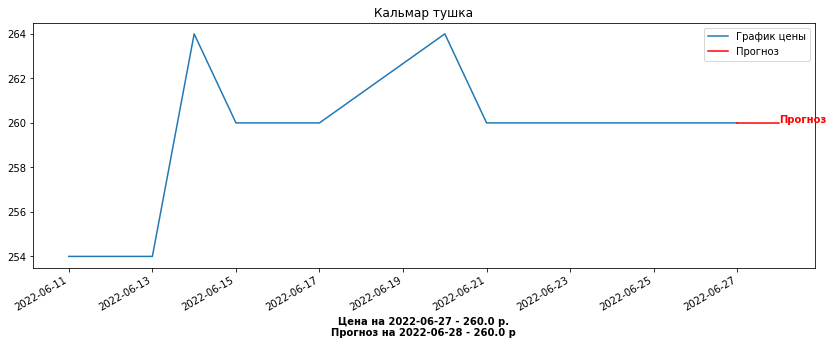

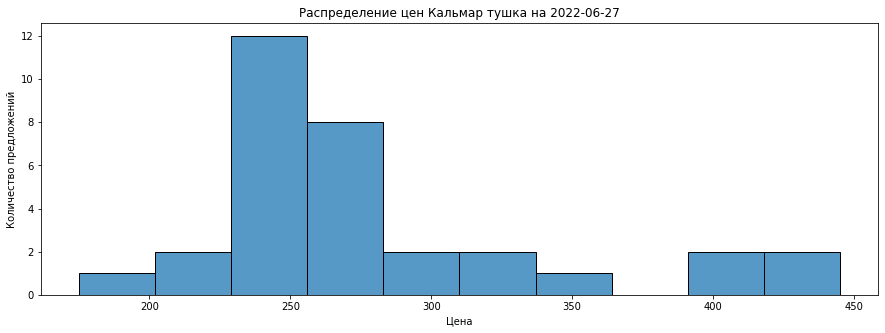

In [ ]:
fish(urleses, cutting_m, 'Кальмар')

# Горбуша new

In [ ]:
urleses = ['https://www.fishnet.ru/pricelist/russia/gorbusha/svejemorojenaya_morojenaya_ryiba_moreproduktyi/',
       'https://www.fishnet.ru/pricelist/russia/gorbusha/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=2',
       'https://www.fishnet.ru/pricelist/russia/gorbusha/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=3',
       'https://www.fishnet.ru/pricelist/russia/gorbusha/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=4',
       'https://www.fishnet.ru/pricelist/russia/gorbusha/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=5',
       'https://www.fishnet.ru/pricelist/russia/gorbusha/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=6',
       'https://www.fishnet.ru/pricelist/russia/gorbusha/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=7',
       'https://www.fishnet.ru/pricelist/russia/gorbusha/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=8']

def cutting_m(i):
  if 'б/г' in i:
    return 'Горбуша ПБГ'
  if 'ПБГ' in i:
    return 'Горбуша ПБГ'
  if 'потр с/г' in i:
    return 'Горбуша ПСГ'
  if 'ПСГ' in i:
    return 'Горбуша ПСГ'
  else:
    return 'Горбуша нр'

['Горбуша ПБГ' 'Горбуша нр' 'Горбуша ПСГ']
[310, 235, 225, 210, 419, 267, 257, 221, 221, 268, 180, 255, 245, 165, 245, 219, 195, 185, 247, 197, 205, 198, 193, 185, 180, 218, 250, 186, 177, 208, 280, 330, 188, 245, 190, 245, 205, 194, 150, 250, 195, 170, 240, 255, 215, 245, 200, 210, 280, 415, 242, 368, 195, 180, 310, 300, 195, 180, 200, 200, 325, 196, 196, 260, 185, 248, 273, 245, 270, 212, 230, 215, 225, 160, 285, 185, 215, 290, 230, 320, 210, 250, 290, 268, 216, 188, 210, 240, 175, 230, 200, 160, 206, 263, 236, 195, 212, 206, 263, 236, 195, 212]
[207, 185, 179, 155, 155, 175, 220, 220, 215, 215, 195, 185, 200, 200, 175, 185, 200, 170, 173, 193, 198, 275, 215, 185, 180, 58, 245, 190, 190, 167, 157, 175, 180, 175, 170, 185, 185, 105, 175, 168, 168, 172, 210, 180, 165, 200, 220, 230, 200, 185, 220, 170, 170, 170, 160, 160, 169, 185, 180, 275, 275, 279, 195, 75, 200, 200, 220, 160, 220, 450, 250, 175, 185, 145, 188, 191, 202, 196, 218, 201, 188, 200, 190, 220, 220, 203, 202, 203, 202]
[2

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dis

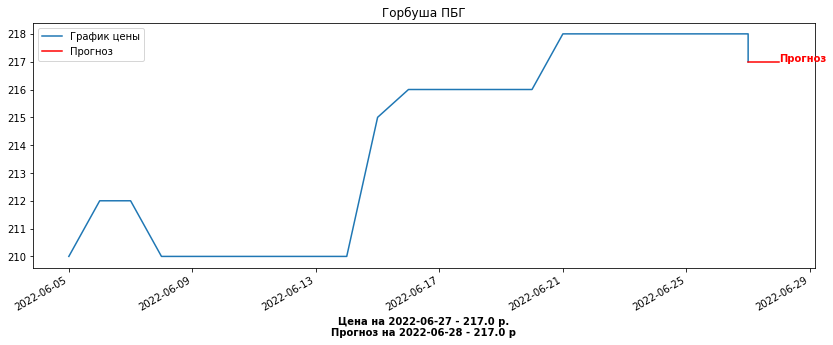

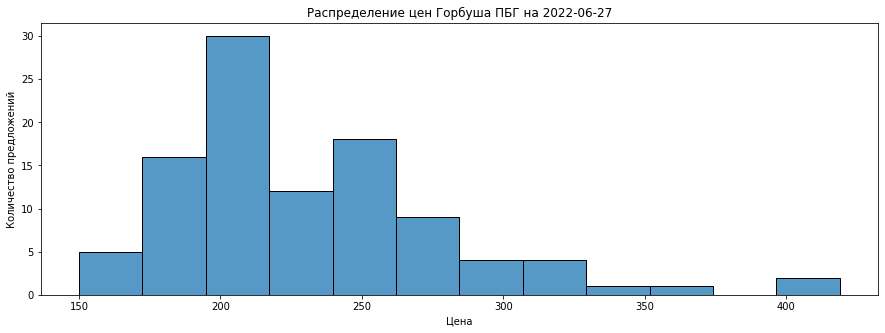

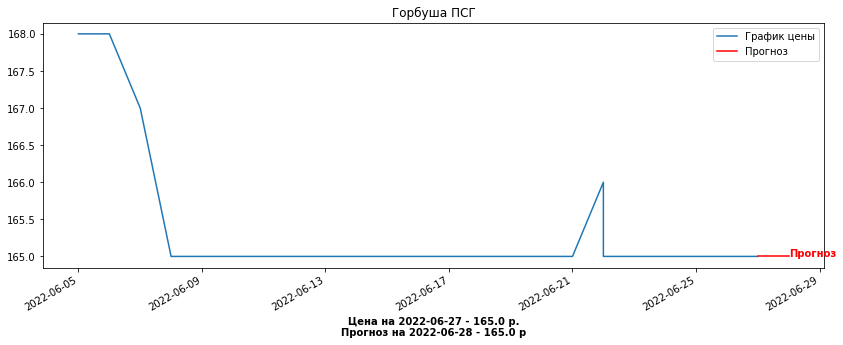

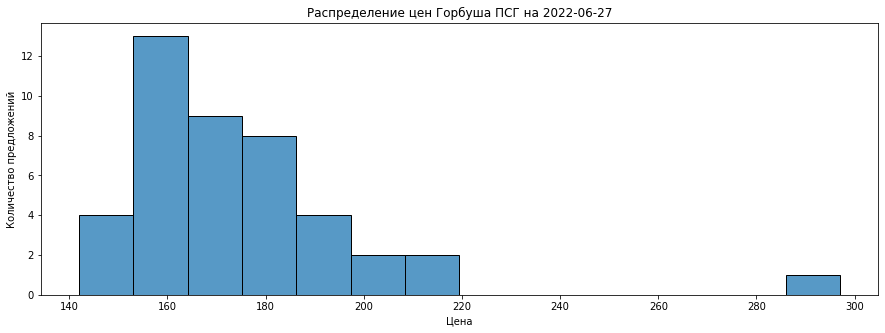

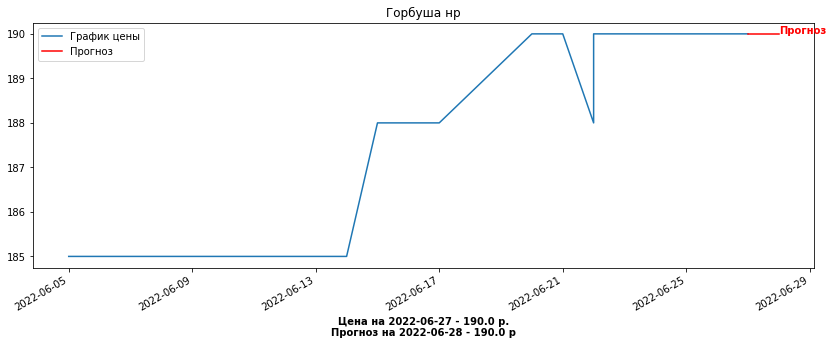

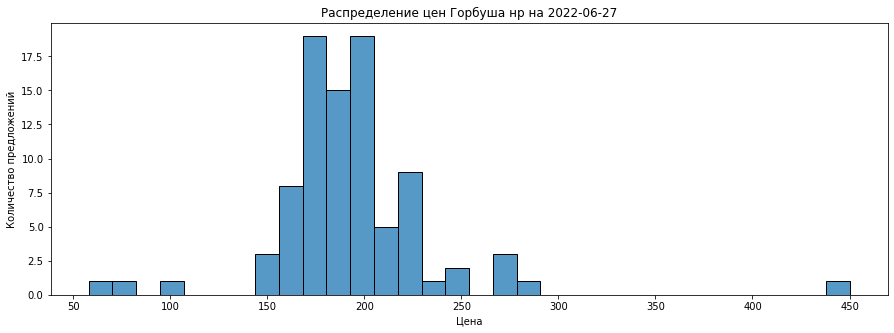

In [ ]:
fish(urleses, cutting_m, 'Горбуша')

# Мойва new

In [ ]:
urleses = ['https://www.fishnet.ru/pricelist/russia/moyva/svejemorojenaya_morojenaya_ryiba_moreproduktyi/',
      'https://www.fishnet.ru/pricelist/russia/moyva/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=2',
      'https://www.fishnet.ru/pricelist/russia/moyva/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=3',
      'https://www.fishnet.ru/pricelist/russia/moyva/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=4']

def cutting_m(i):
  if '25-30' in i:
    return 'Мойва нр 25-30'
  if '30-40' in i:
    return 'Мойва нр 30-40'
  if '25-35' in i:
    return 'Мойва нр 25-35'
  if '40-50' in i:
    return 'Мойва нр 40-50'
  if '45-55' in i:
    return 'Мойва нр 45-55'
  if '35-45' in i:
    return 'Мойва нр 35-45'
  if '35-40' in i:
    return 'Мойва нр 35-40'
  if ' 25/35' in i:
    return 'Мойва нр 25-35'
  if '26-29' in i:
    return 'Мойва нр 26-29'
  else:
    return 'No'

['Мойва нр 25-35' 'Мойва нр 30-40' 'Мойва нр 35-45' 'Мойва нр 35-40'
 'Мойва нр 25-30' 'Мойва нр 26-29' 'Мойва нр 40-50']
[125, 150, 130, 245, 160, 190, 205, 209, 140, 150, 208, 205, 115, 245, 210]
[185, 215, 259, 132, 175, 190, 194, 230, 220, 178, 175, 180, 180, 183, 184, 184]
[177, 249, 195, 170, 174, 220, 163, 160, 160, 165, 162]
[155]
[155, 139]
[125, 115]
[153, 150]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dis

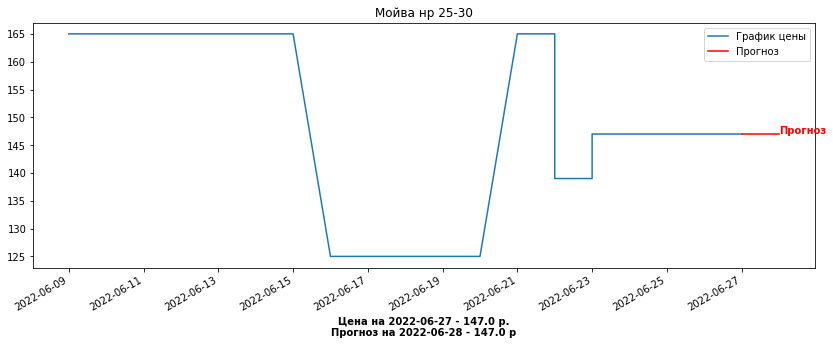

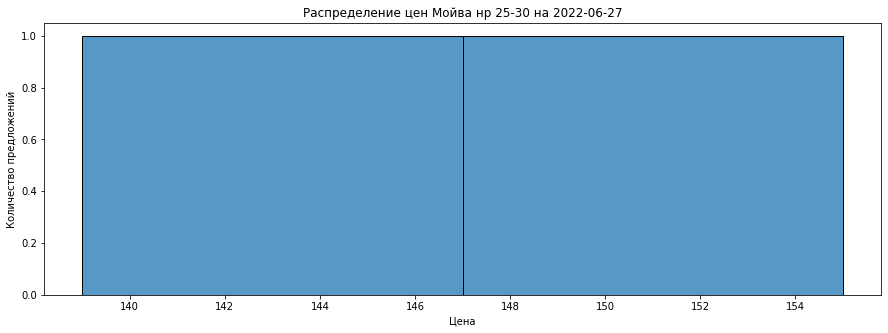

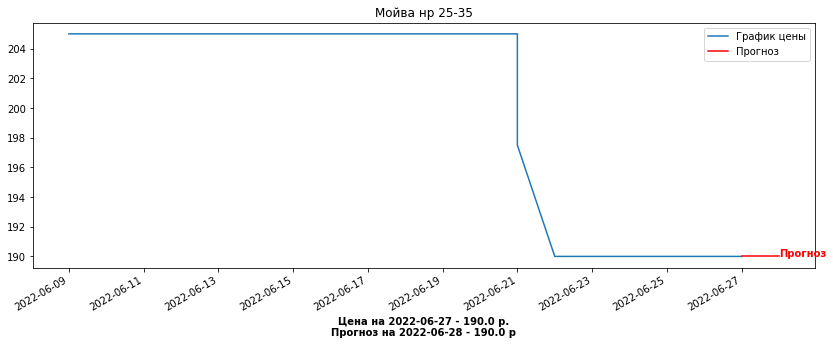

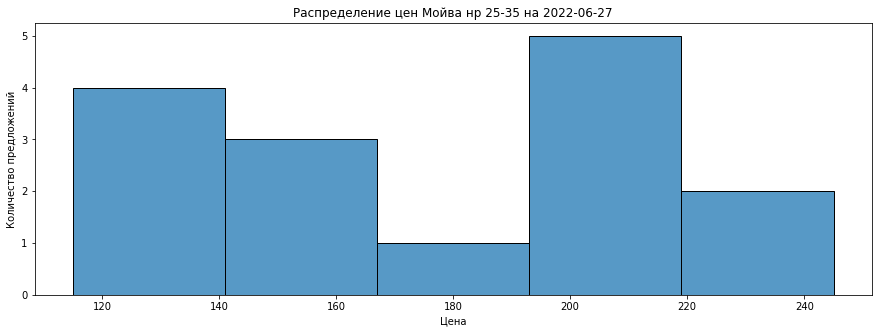

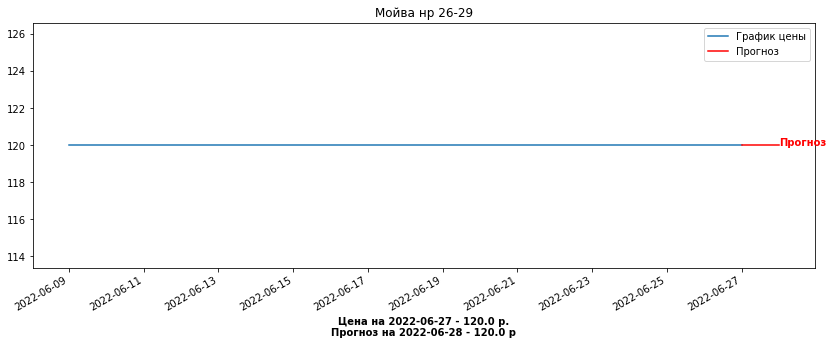

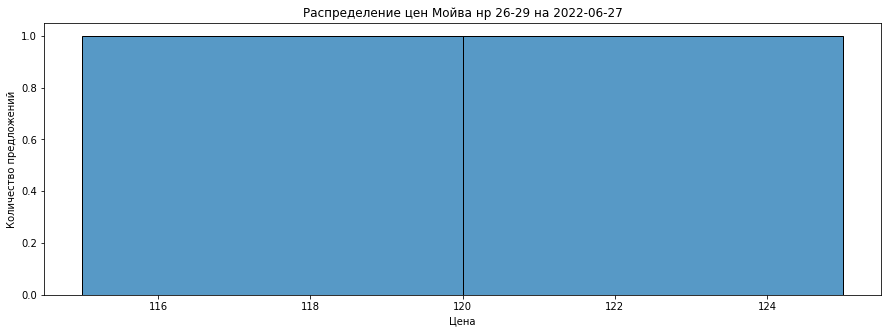

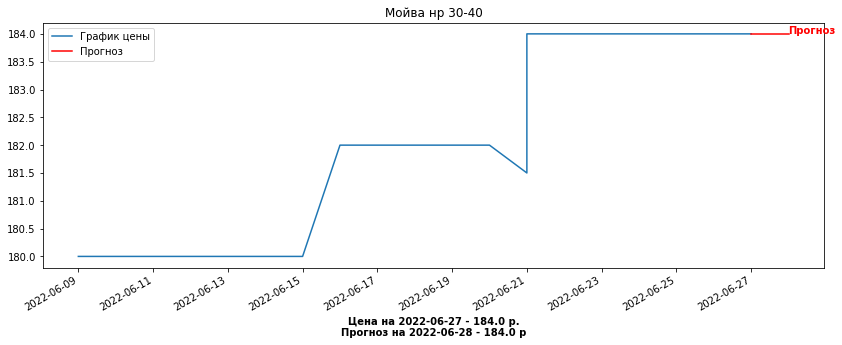

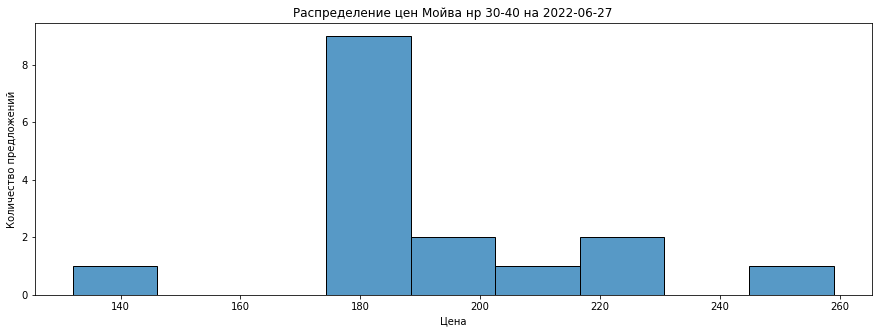

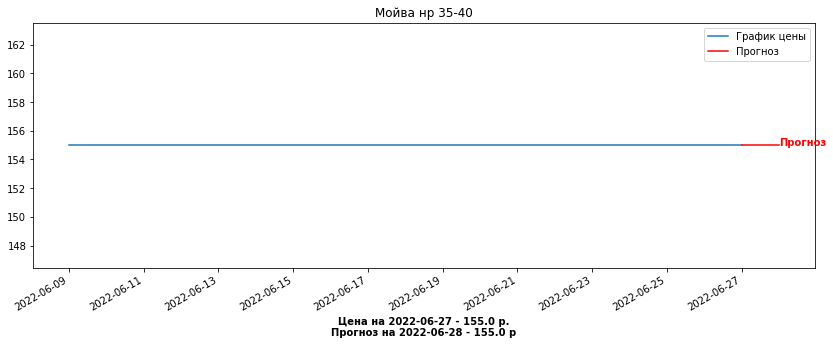

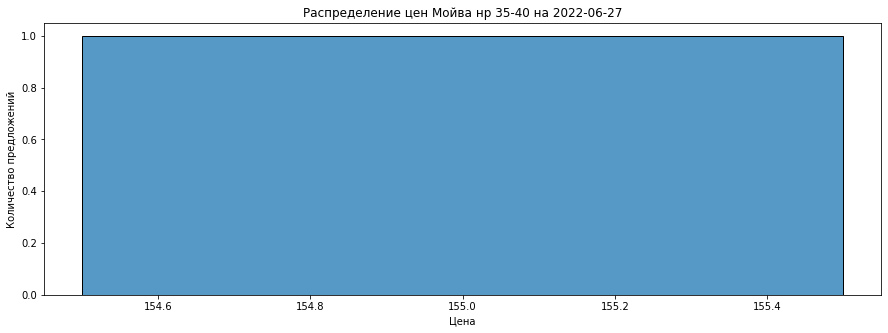

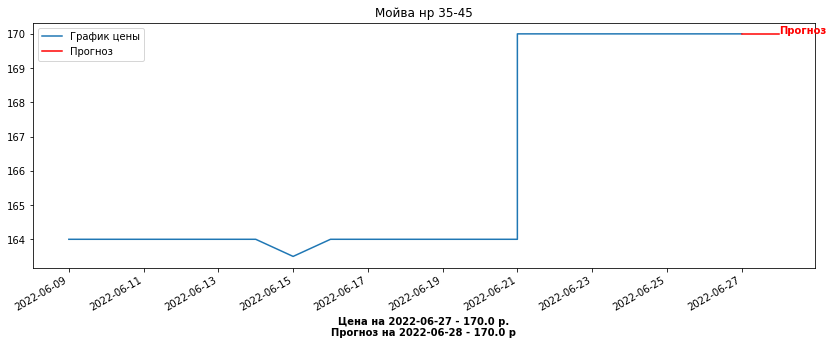

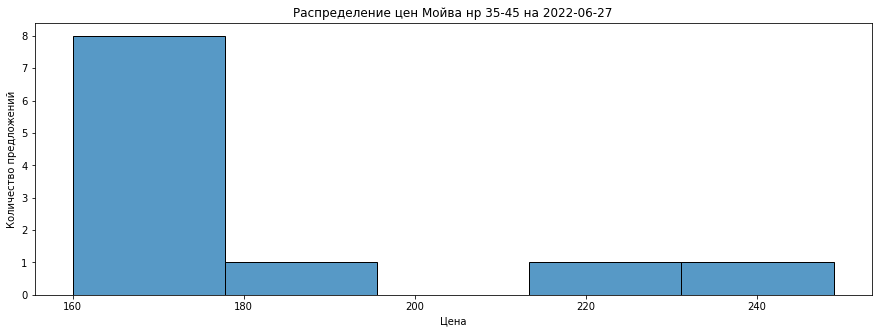

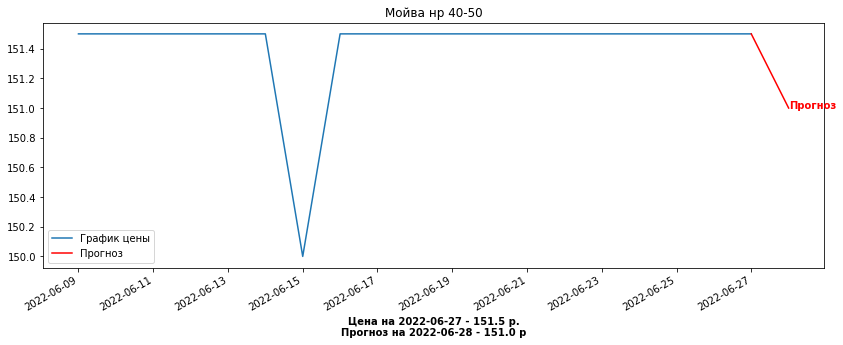

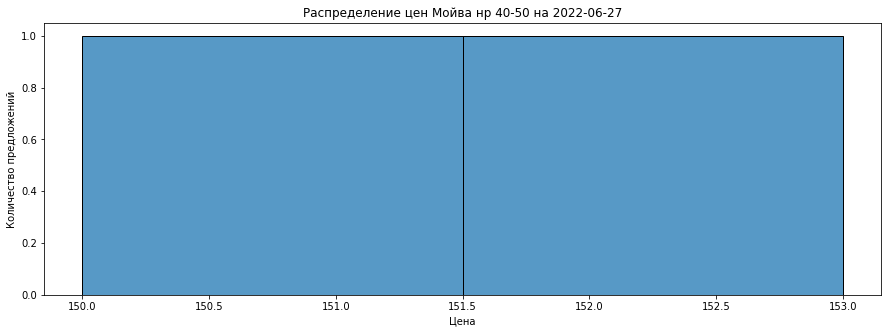

In [ ]:
fish(urleses, cutting_m, 'Мойва')

# Минтай new

In [ ]:
urleses = ['https://www.fishnet.ru/pricelist/russia/mintay/svejemorojenaya_morojenaya_ryiba_moreproduktyi/',
      'https://www.fishnet.ru/pricelist/russia/mintay/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=2',
      'https://www.fishnet.ru/pricelist/russia/mintay/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=3',
      'https://www.fishnet.ru/pricelist/russia/mintay/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=4',
      'https://www.fishnet.ru/pricelist/russia/mintay/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=5']

def cutting_m(i):
  if '20+' in i:
    return 'Минтай бг 20+'
  if '20-25' in i:
    return 'Минтай бг 20+'
  if '25+' in i:
    return 'Минтай бг 25+'
  if '25-30' in i:
    return 'Минтай бг 25+'
  if '30+' in i:
    return 'Минтай бг 30+'
  if '30-35' in i:
    return 'Минтай бг 30+'
  if '35+' in i:
    return 'Минтай бг 35+'
  if '35-40' in i:
    return 'Минтай бг 35+'
  if 'S' in i:
    return 'Минтай бг 20+'
  if 'M' in i:
    return 'Минтай бг 25+'
  if 'L' in i:
    return 'Минтай бг 30+'
  else:
    return 'No'

['Минтай бг 20+' 'Минтай бг 30+' 'Минтай бг 25+' 'Минтай бг 35+']
[109, 112, 117, 110, 100, 102, 118, 110, 105, 115, 102, 112, 100, 100, 104, 105, 116, 113, 113, 109, 128, 111, 111, 114]
[172, 130, 134, 145, 145, 135, 115, 130, 135, 123, 155, 145, 140, 140, 137, 135, 135, 130, 135, 133, 133, 126, 143, 125, 150, 130, 130, 160, 168, 130, 110, 136, 135, 138, 165, 135, 138, 135]
[121, 132, 166, 118, 106, 123, 115, 105, 105, 101, 151, 120, 135, 135, 135, 105, 105, 104, 107, 111, 115, 105, 110, 110, 115, 118, 110, 118, 107, 105, 101, 101, 108, 113, 108, 105, 109, 116, 116, 141, 139, 138, 137, 107, 108, 106, 107, 108, 116]
[145, 140, 145, 165, 143, 135, 152, 168]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dis

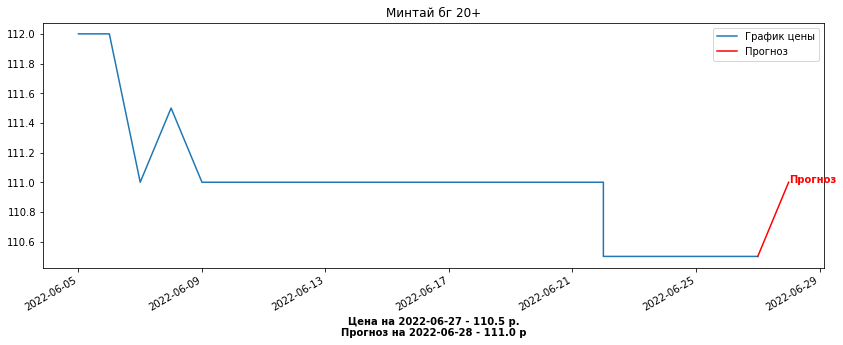

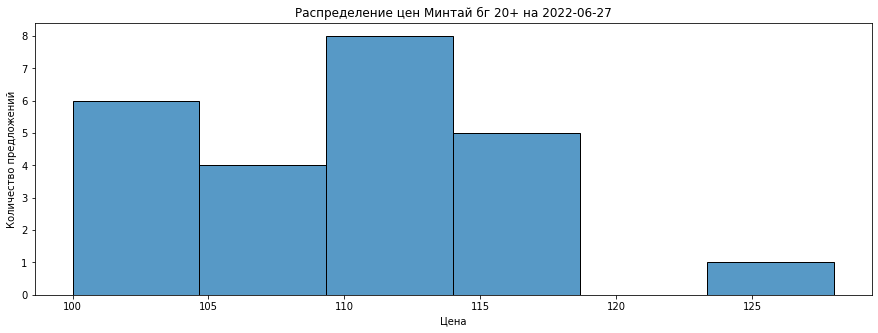

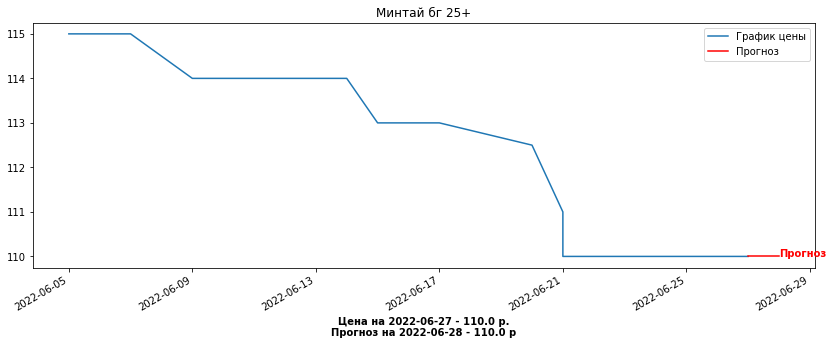

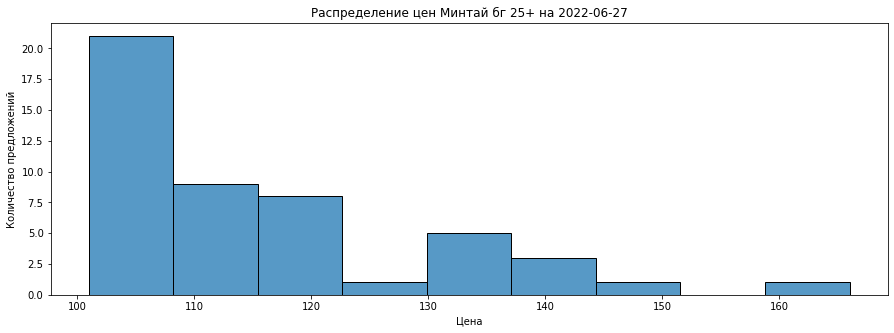

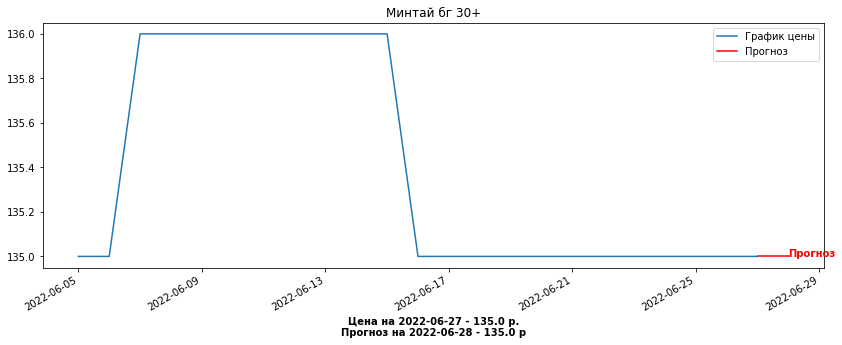

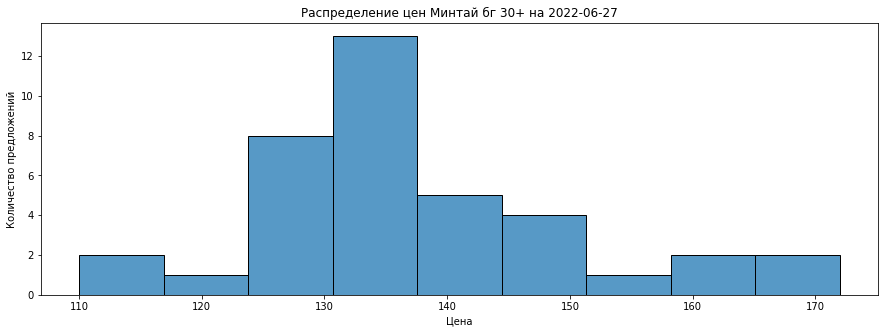

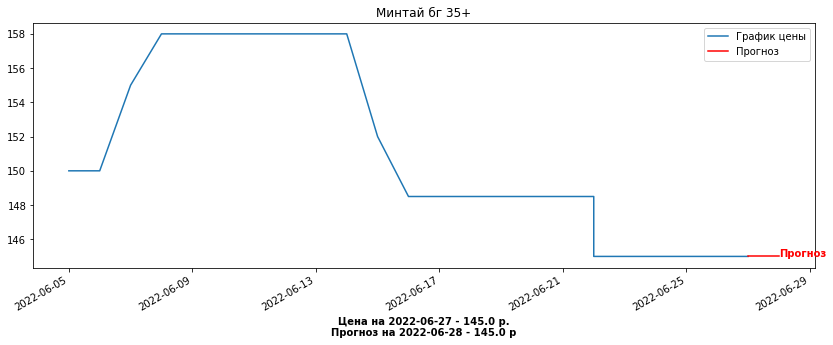

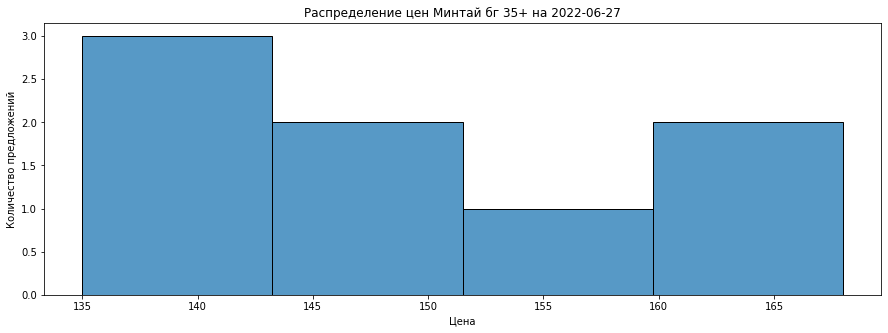

In [ ]:
fish(urleses, cutting_m, 'Минтай')

# Лосось

In [ ]:
urleses = ['https://www.fishnet.ru/pricelist/russia/losos/svejemorojenaya_morojenaya_ryiba_moreproduktyi/',
         'https://www.fishnet.ru/pricelist/russia/losos/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=2',
         'https://www.fishnet.ru/pricelist/russia/losos/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=3',
         'https://www.fishnet.ru/pricelist/russia/losos/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=4',
         'https://www.fishnet.ru/pricelist/russia/losos/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=5',
         'https://www.fishnet.ru/pricelist/russia/losos/svejemorojenaya_morojenaya_ryiba_moreproduktyi/?page=6']

def cutting_m(i):
  if 'Молоки' in i:
    return 'No'
  if 'Брюшк' in i:
    return 'No'
  if 'Голов' in i:
    return 'No'
  if 'Хребт' in i:
    return 'No'
  if '7-8' in i:
    return 'Лосось псг 7-8кг'
  if '6-7' in i:
    return 'Лосось псг 6-7кг'
  if '5-6' in i:
    return 'Лосось псг 5-6кг'
  if '4-5' in i:
    return 'Лосось псг 4-5кг'
  if '2-3' in i:
    return 'Лосось псг 2-3кг'
  if '1-2' in i:
    return 'Лосось псг 1-2кг'
  if '3-4' in i:
    return 'Лосось псг 3-4кг'
  if '7/8' in i:
    return 'Лосось псг 7-8кг'
  if '6/7' in i:
    return 'Лосось псг 6-7кг'
  if '5/6' in i:
    return 'Лосось псг 5-6кг'
  if '4/5' in i:
    return 'Лосось псг 4-5кг'
  if '2/3' in i:
    return 'Лосось псг 2-3кг'
  if '1/2' in i:
    return 'Лосось псг 1-2кг'
  if '3/4' in i:
    return 'Лосось псг 3-4кг'
  if '8-9' in i:
    return 'Лосось псг 8-9кг'
  if '9-10' in i:
    return 'Лосось псг 9-10кг'
  if '8/9' in i:
    return 'Лосось псг 8-9кг'
  if '9/10' in i:
    return 'Лосось псг 9-10кг'
  else:
    return 'No'

['Лосось псг 7-8кг' 'Лосось псг 6-7кг' 'Лосось псг 5-6кг'
 'Лосось псг 4-5кг' 'Лосось псг 2-3кг' 'Лосось псг 1-2кг'
 'Лосось псг 8-9кг' 'Лосось псг 3-4кг']
[807, 900]
[797, 890]
[782, 850]
[767, 790]
[767, 890, 950, 780]
[727, 800, 158, 740]
[900]
[780]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:924: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:930: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associ

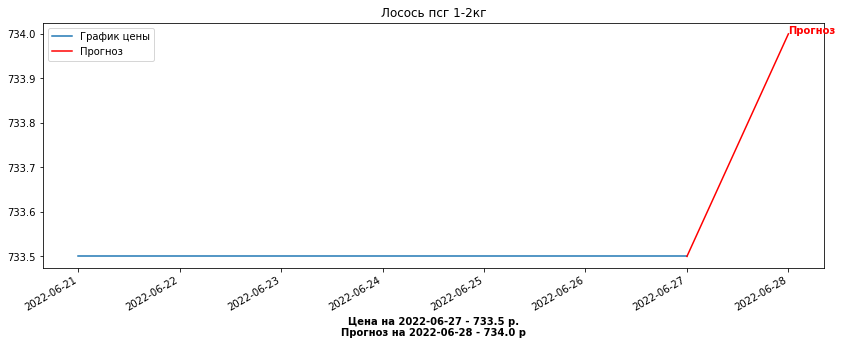

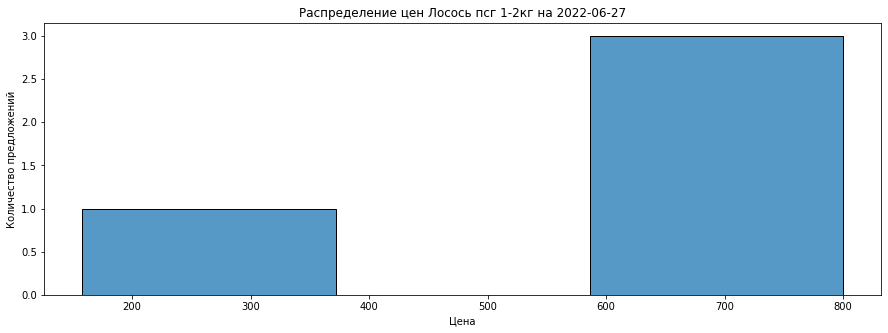

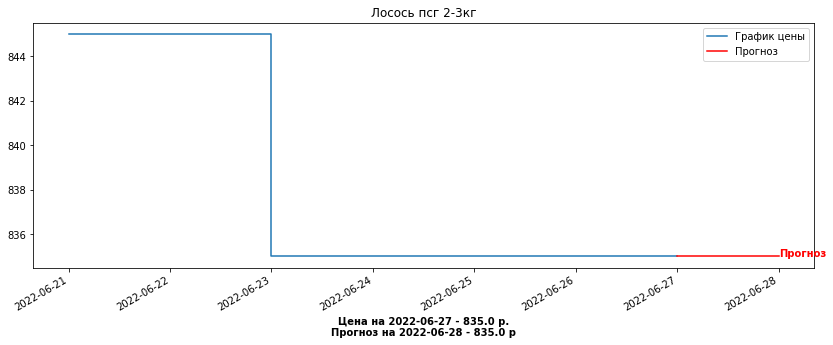

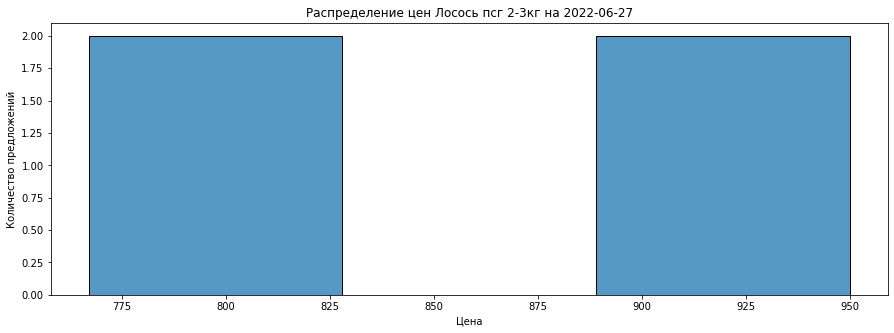

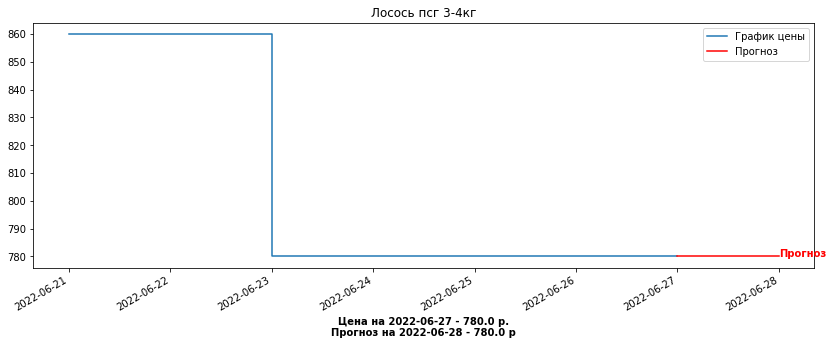

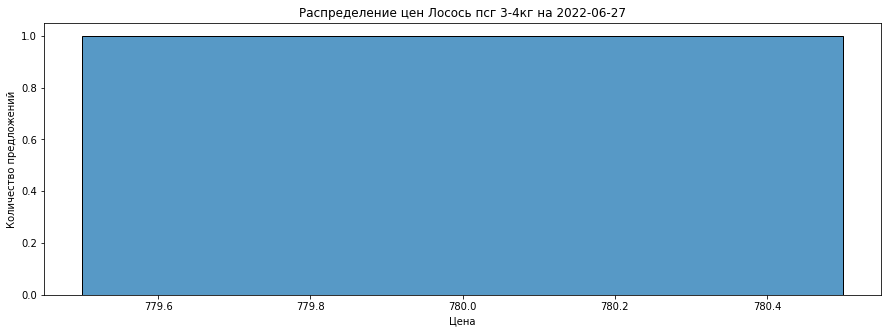

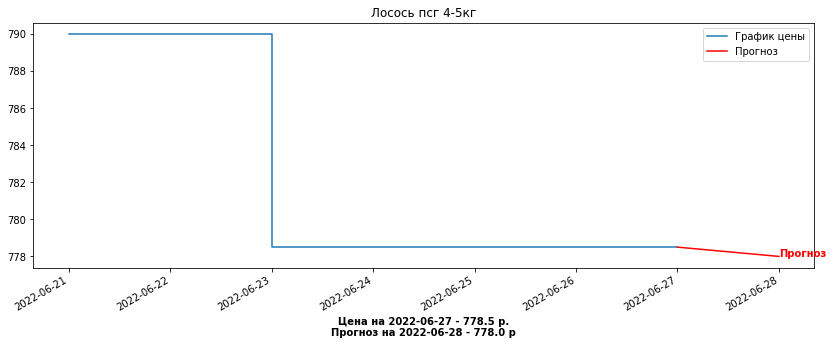

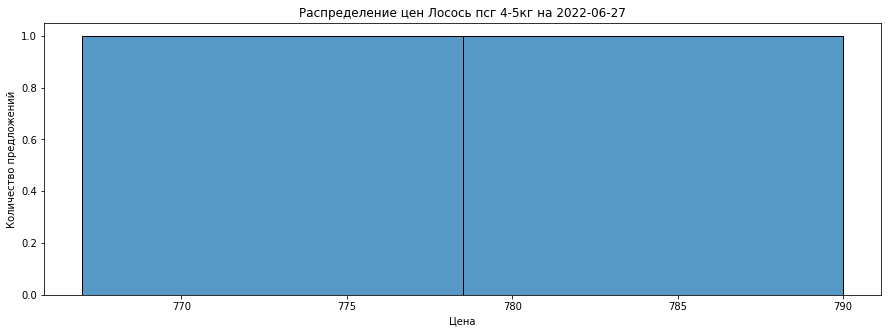

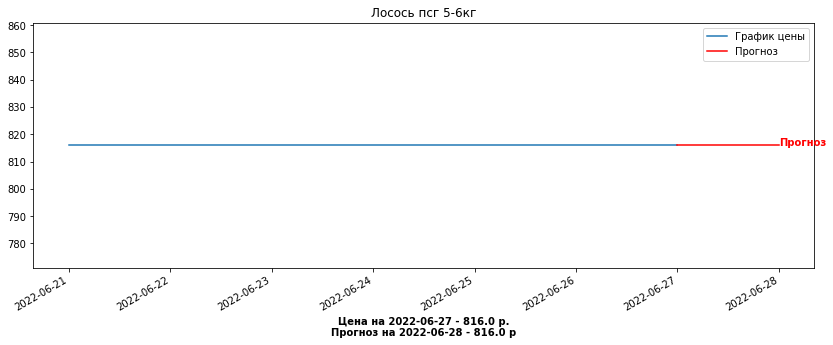

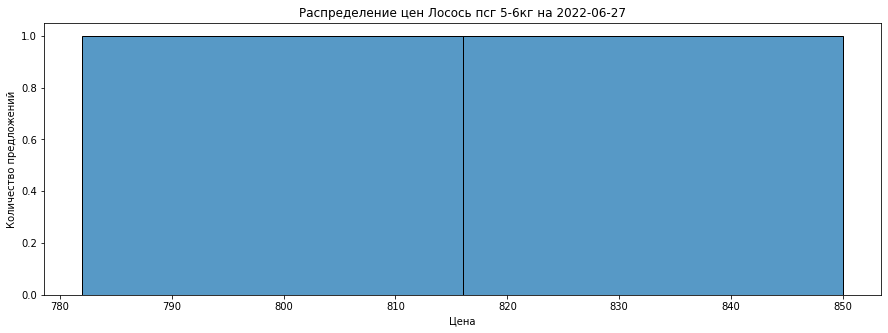

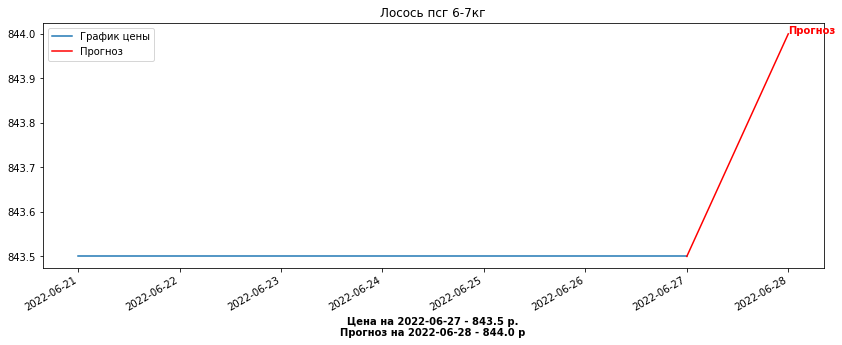

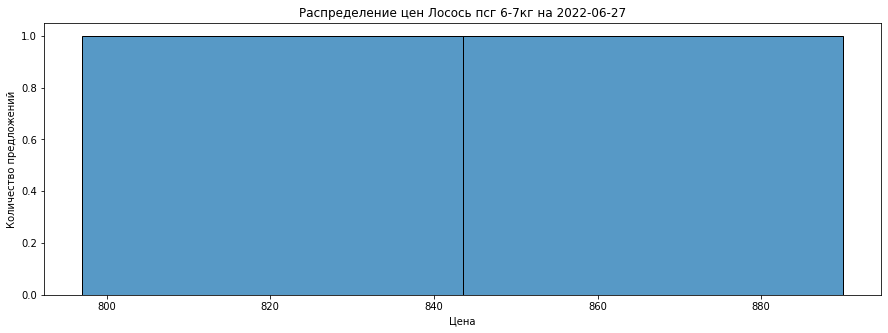

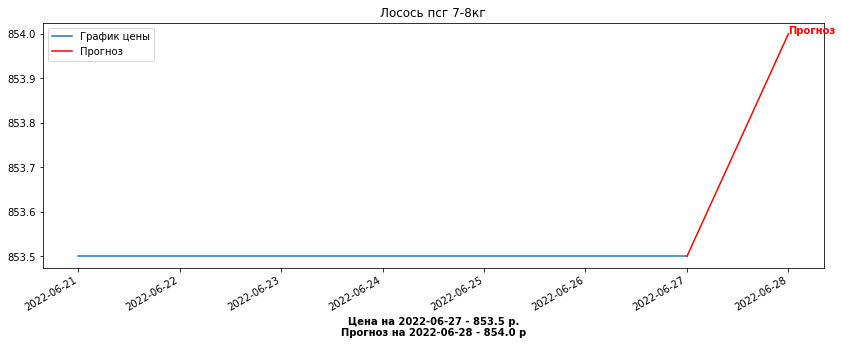

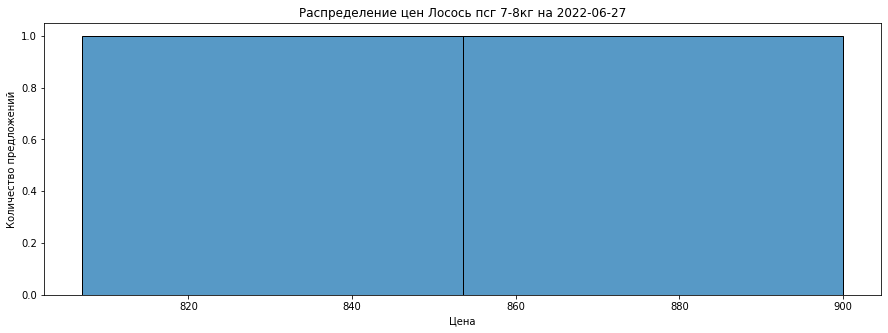

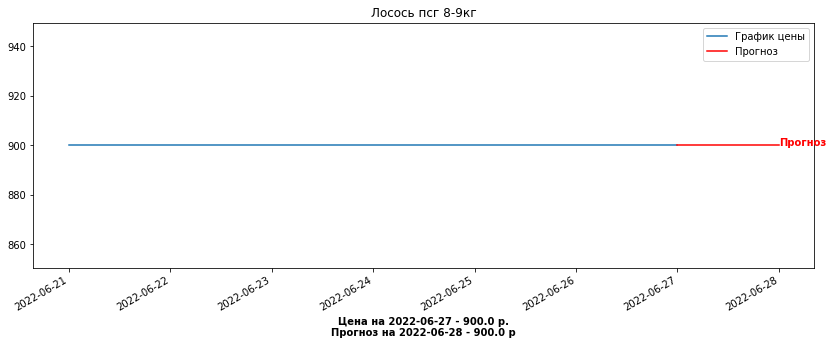

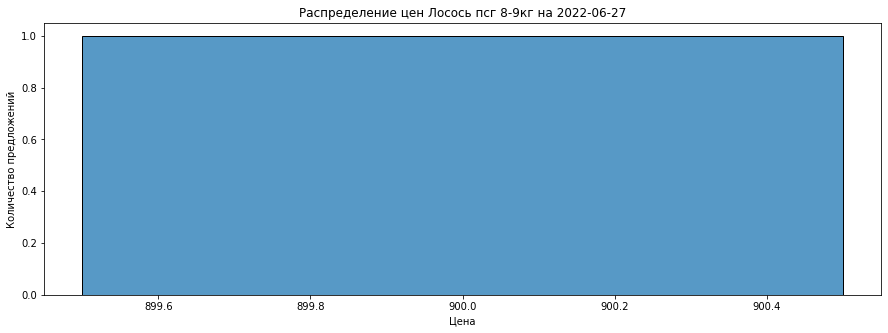

In [ ]:
fish(urleses, cutting_m, 'Лосось')

# Салака

In [ ]:
urleses = ['https://www.fishnet.ru/pricelist/russia/salaka/svejemorojenaya_morojenaya_ryiba_moreproduktyi/']

def cutting_m(i):
  if 'окисл' in i:
    return 'No'
  if 'Салака' in i:
    return 'Салака'
  if 'салака' in i:
    return 'Салака'
  if 'САЛАКА' in i:
    return 'Салака'
  else:
    return 'No'

['Салака']
[85, 94, 85, 105, 105, 114, 109, 77, 70, 89, 75, 90, 80, 120, 120, 85, 100, 115, 115, 105, 111, 115, 145, 101, 85, 119, 95, 106, 98]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:924: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:930: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


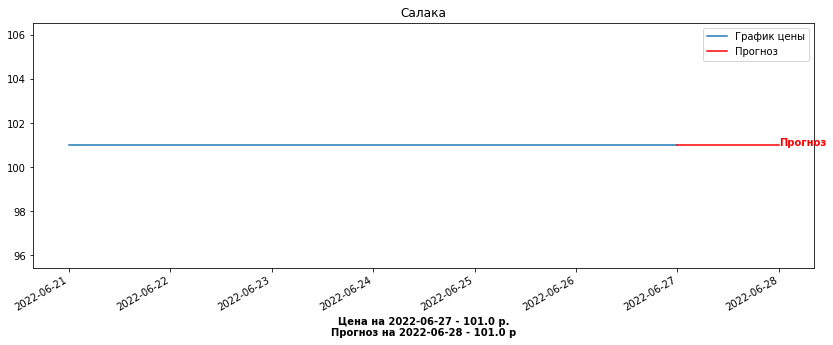

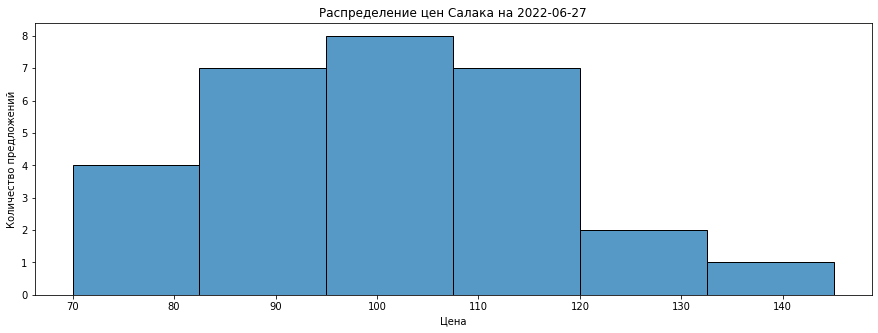

In [ ]:
fish(urleses, cutting_m, 'Салака')

# Лемонема

In [ ]:
urleses = ['https://www.fishnet.ru/pricelist/russia/lemonema/svejemorojenaya_morojenaya_ryiba_moreproduktyi/']

def cutting_m(i):
  if 'молок' in i:
    return 'No'
  if 'Молок' in i:
    return 'No'
  if 'Лемонема' in i:
    return 'Лемонема тушка'
  if 'Лемонела' in i:
    return 'Лемонема тушка'
  if 'ЛЕМОНЕМА' in i:
    return 'Лемонема тушка'
  if 'Леманема' in i:
    return 'Лемонема тушка'
  else:
    return 'No'

['Лемонема тушка']
[177, 150, 145, 150, 140, 150, 152, 177, 120, 125, 180, 135, 144, 160, 153, 135, 158]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:924: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:930: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


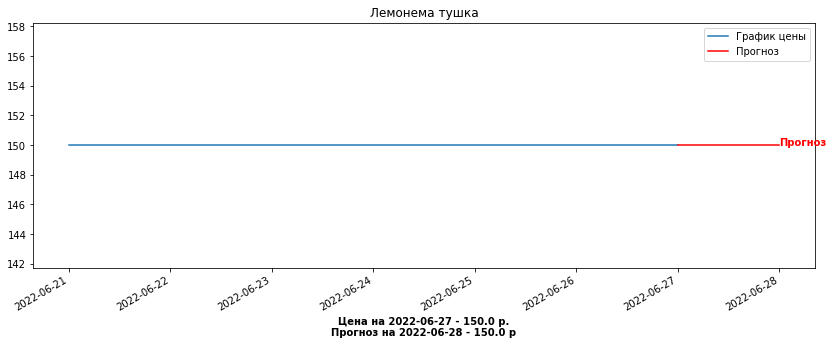

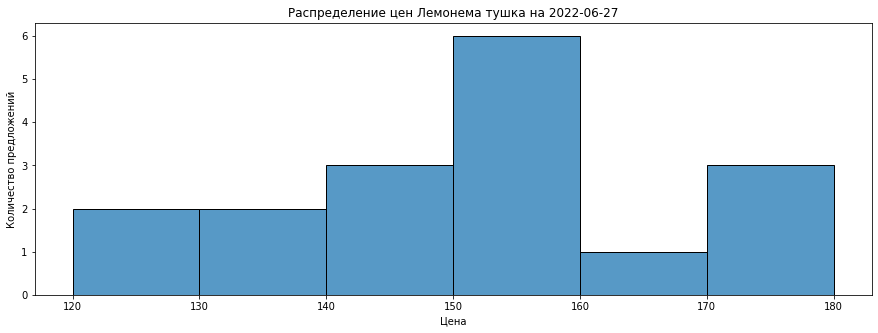

In [ ]:
fish(urleses, cutting_m, 'Лемонема')